## 당뇨병 유무와 신체검사 데이터
1. 시각화를 포함하여 탐색적 자료 분석(EDA)
2. 이상치를 식별하고 처리
3. 클래스의 불균형을 처리 
4. Linear Regression, svm, xgboost를 사용하여 모델링 비교
5. 속도 개선을 위한 차원 축소 후 예측 성능과 속도를 비교

### EDA

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df1 = pd.read_csv('./data/diabetes_for_test.csv')
df1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [33]:
## 당뇨의 유무에 따른 독립변수 분포 확인
diabetes = df1.groupby('Outcome').mean()
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,36.934000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


Text(0.5, 0.98, 'EDA')

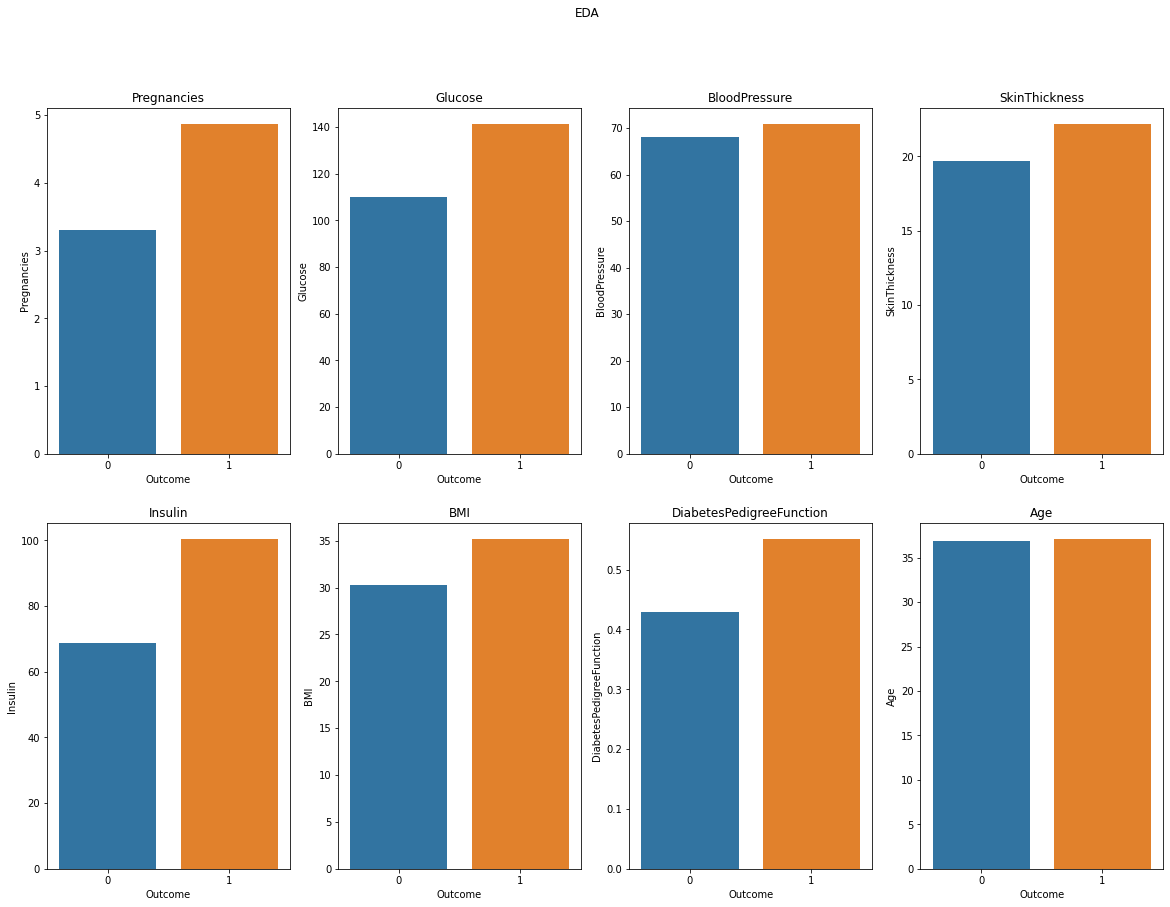

In [34]:
## 분포를 시각화
fig, axes = plt.subplots(2, 4, figsize=(20, 14))
for i in range(4) : 
    sns.barplot(data=diabetes, x=diabetes.index, y=diabetes.iloc[:, i], ax = axes[0][i] )
    axes[0][i].set_title(diabetes.columns[i])
for i in range(4) : 
    sns.barplot(data=diabetes, x=diabetes.index, y=diabetes.iloc[:, i+4], ax = axes[1][i])
    axes[1][i].set_title(diabetes.columns[i+4])

plt.suptitle("EDA")


- 당뇨병이 있는 사람은 없는 사람보다 pregnancies의 평균 수치가 높다.
- 당뇨병이 있는 사람은 없는 사람 보다 Glucose의 평균 수치가 높다.
- 당뇨병이 있는 사람은 없는 사람 보다 Insulin의 평균 수치가 높다.
- 당뇨병이 있는 사람은 없는 사람 보다 BMI의 평균 수치가 높다.

<AxesSubplot:>

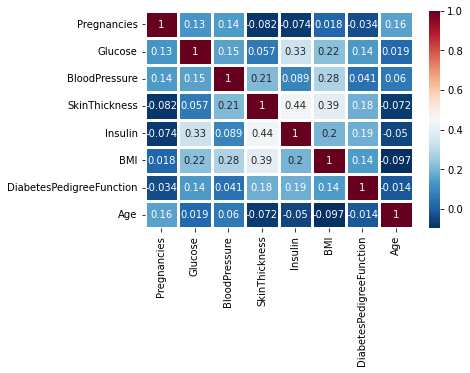

In [35]:
## Outcome을 제외한 변수들 간의 상관성을 보았을 때, 0.9 이상의 상관관계를 가지는 변수는 없었다. 
# 그러므로 모든 변수를 사용하여 모델링해도 될 것으로 판단된다. 
import seaborn as sns

df_cor = df1.drop(columns=["Outcome"]).corr(method='pearson')
sns.heatmap(df_cor,
           xticklabels = df_cor.columns,
           yticklabels = df_cor.columns,
           cmap='RdBu_r',
           annot=True, 
           linewidth=3)


### 이상치 식별 및 처리

In [36]:
df1.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,36.980469,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,61.404453,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,999.000000,1.000000


우선 describe로 변수들을 살펴보았을 때, 각 변수들의 결측치는 없는 것을 확인하였다. 이상치를 판단하기 위해서는 mean, min, max값을 확인하는 것이 좋다. 평균과 min, 평균과 max 값이 std에 비해 한참 차이가 난다면, 이상치가 있을 가능성이 높다. 
이러한 이상치를 정확히 판단하기 위해서는 아래와 같이 boxplot으로 시각화하여 보는 것이정확하다. 


In [37]:
X = df1.drop(columns=['Outcome'])
df_v1 = pd.melt(X ,var_name='col', value_name='value')
df_v1

,col,value
0,Pregnancies,6.0
1,Pregnancies,1.0
2,Pregnancies,8.0
3,Pregnancies,1.0
4,Pregnancies,0.0
...,...,...
6139,Age,63.0
6140,Age,27.0
6141,Age,30.0
6142,Age,47.0


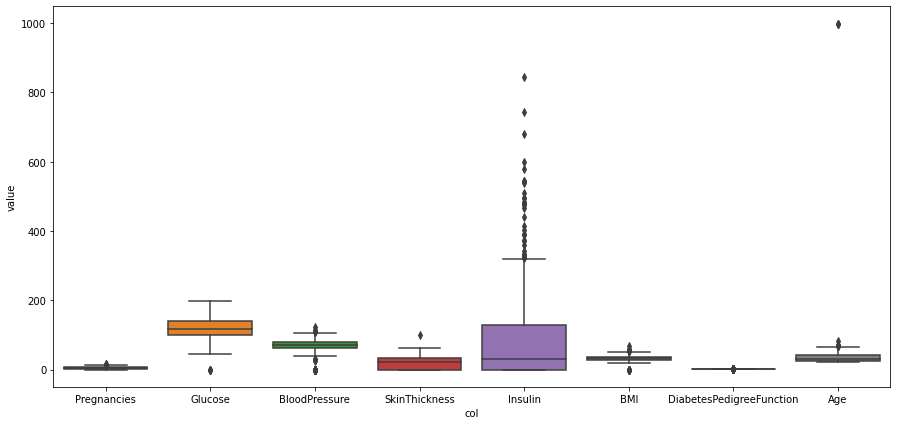

In [38]:
plt.figure(figsize = (15, 7))
sns.boxplot(x = 'col', y = 'value', data = df_v1)
plt.xticks(range(8), X.columns)
plt.show()

Age의 경우 중앙값과 멀리 떨어진 이상치가 눈의 띈다. 
insulin의 경우도 이상치는 존재하지만, 이상치들이 연속적으로 이어져 있어 실제로 이상치를 가진 사람이 있을 수 있다는 가정하에 Age의 이상치만 처리 

Age의 중앙값 :  29.0


<AxesSubplot:>

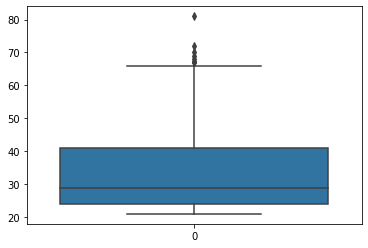

In [39]:
## Age 컬럼에 눈에띄는 이상치(999)가 있어 Age의 중앙값인 29 로 이상치를 대체한다. 
print("Age의 중앙값 : ",  df1.Age.median()) 
outlier_index = df1[df1['Age']>150].index
df1.loc[outlier_index,'Age']=df1.Age.median()

sns.boxplot(df1["Age"])

In [40]:
## 추가적으로 데이터를 살펴 보았을 때, 
# Glucose와 BloodPressure컬럼에는 0이 존재하지 않아야 된다고 판단되었다. 
# 이를 이상치라고 판단하여 이상치를 제외한 중앙값으로 이상치를 대체하였다.
outlier_index = df1[df1['Glucose']== 0].index
df1.loc[outlier_index,'Glucose']=df1.Glucose.median()
outlier_index = df1[df1['BloodPressure']== 0].index
df1.loc[outlier_index,'BloodPressure']= df1.BloodPressure.median()

df1.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,20.536458,79.799479,31.992578,0.471876,33.191406,0.348958
std,3.369578,30.438286,12.096642,15.952218,115.244002,7.884160,0.331329,11.683509,0.476951
min,0.000000,44.000000,24.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


위에 describe() 함수를 보게 되면, 최솟값과 최댓값 차이가 많이 나는 컬럼이 존재한다. 따라서 선형모델 사용시 scale을 적용할 필요가 보인다.

### 데이터의 불균형 처리
- 현 데이터가 총 768개로 적은 데이터가 존재한다.. 따라서, undersampling을 선택하게 되면 데이터가 더 적어지기 때문에 오버피팅이 일어날 위험이 더 크다.  
**oversampling을 선택할 것 이다**.

### 모델링 
- Linear regression, svm, xgboost를 실행

In [41]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sklearn.svm as svm

log = LogisticRegression()
xgb = XGBClassifier(random_state=0)
svm_clf =svm.SVC(kernel = 'linear')

In [42]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import time
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X = df1.drop(['Outcome'],axis=1)
y = df1[['Outcome']]

## 5개의 경우의 수로 분할하여 검증 
kfold = KFold()
def model_result(model):
    pred_li =[]
    for train_index,test_index in kfold.split(X):
        X_train,X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train,y_test = y.iloc[train_index,:],y.iloc[test_index,:]
        
        X_train_resample,y_train_resample = smote.fit_resample(X_train,y_train)
        
        start = time.time()
        model.fit(X_train_resample,y_train_resample)
        end = time.time()
        
        pred = model.predict(X_test)
        pred_li.append(accuracy_score(pred,y_test['Outcome']))
        
    ## 마지막 데이터 학습 속도     
    print(f"{end - start:.5f} sec")
    ## 5개의 train데이터에 대한 정확도의 평균 값  
    print(np.mean(pred_li))



In [43]:
model_result(log)

0.01152 sec
0.7527119938884643


In [44]:
model_result(xgb)

0.06263 sec
0.7474492827434004


In [45]:
model_result(svm_clf)

1.89965 sec
0.7618198794669383


데이터 수가 적기 때문에 hold-out 기법이 아니라 cross-validation 기법으로 성능을 확인하였고, 위에서 말했던거와 같이 oversampling 기법인 smote를 활용하였다.  
따라서, 역시나 logistic이 가장 빨랐으며 svm이 성능이 가장 좋은것을 확인할수있었다.

### 속도 개선을 위한 차원 축소 후 수행 예측 성능과 속도 비교

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

smote = SMOTE(random_state=0)

X_train, X_test, y_train, y_train = train_test_split(X,y, stratify=y, test_size=0.3, random_state=2022)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)

pca = PCA(n_components=8)
X_train_pca = pca.fit(X_train_s)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_[:5].sum())

[0.26110315 0.22613628 0.12025873 0.10650649 0.1016306  0.08197042
 0.05251497 0.04987936]
0.8156352463546329


- 차원 축소 방법으로는 PCA를 사용
- PCA를 사용하는 경우는 데이터 스케일에 따라 주 성분이 설명가능한 분산량이 달라질 수 있기 때문에 데이터 스케일링 작업을 해주어야 한다. 
- 독립 변수까지 차원 축소시켜 적절한 주성분의 개수를 찾아 보면 8개의 독립 변수 대신 5개 주 성분까지 사용하면, 전체 데이터에 81%를 설명할 수 있음을 파악

In [47]:
def pca_model_result(model):
    pred_li =[]
    for train_index,test_index in kfold.split(X):
        X_train,X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train,y_test = y.iloc[train_index,:],y.iloc[test_index,:]
        
        X_train_resample,y_train_resample = smote.fit_resample(X_train,y_train)
        
        scaler = StandardScaler()
        X_train_res_s = scaler.fit_transform(X_train_resample)
        X_test_s = scaler.transform(X_test)
        
        pca = PCA(n_components=5)
        X_train_pca = pca.fit_transform(X_train_res_s)
        X_test_pca = pca.transform(X_test_s)
        
        start = time.time()
        model.fit(X_train_pca,y_train_resample)
        end = time.time()
        
        pred = model.predict(X_test_pca)
        pred_li.append(accuracy_score(pred,y_test['Outcome']))
        
        
    print(f"{end - start:.5f} sec")
    print(np.mean(pred_li))

In [48]:
pca_model_result(log)

0.00100 sec
0.7279093455564045


In [49]:
pca_model_result(xgb)

0.05708 sec
0.7031491384432561


In [50]:
pca_model_result(svm_clf)

0.01052 sec
0.7253034547152193


예측 성능은 다소 상승되었고 속도 측면에도 차원축소에 의해 더 빨라졌다.  
향후에 데이터가 크게 늘어난다면 성능 및 속도 측면에서 더 유의미한 차이가 클 것으로 보인다.